# YOLOv5 
- roboflow image 학습후 야간 주행 동영상 test
- https://ropiens.tistory.com/44 설명 참고
- object detection과 yolov5 기술에 대한 자료는 보고서로 작성 예정 

- roboflow 'Udacity Self Driving Car Dataset'
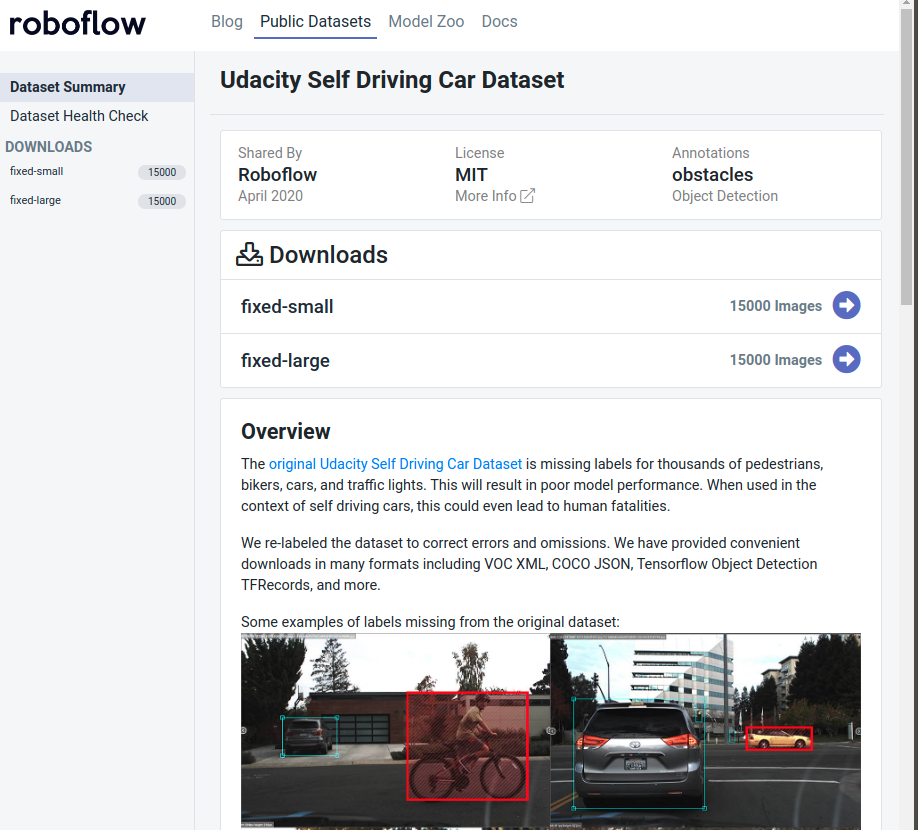

In [ ]:
# roboflow dataset download 15000장 large, small 제공 -> small(512*512 다운 받음)
!curl -L "your link write in here" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

In [5]:
# 현재 폴더에 yolov5 깃 클론

%cd /home/piai/AI project test
!git clone https://github.com/ultralytics/yolov5.git

/home/piai/AI project test
'yolov5'에 복제합니다...
remote: Enumerating objects: 5595, done.
remote: Total 5595 (delta 0), reused 0 (delta 0), pack-reused 5595
오브젝트를 받는 중: 100% (5595/5595), 8.18 MiB | 11.76 MiB/s, 완료.
델타를 알아내는 중: 100% (3825/3825), 완료.


In [6]:
# yolov5 실행에 필요한 패키지 다운

%cd /home/piai/AI project test/yolov5/
!pip install -r requirements.txt

/home/piai/AI project test/yolov5
     |████████████████████████████████| 662 kB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 74 kB 2.3 MB/s eta 0:00:011
     |████████████████████████████████| 10.6 MB 12.7 MB/s eta 0:00:01   |███████▉                        | 2.6 MB 7.3 MB/s eta 0:00:02
  Using cached Cython-0.29.22-cp38-cp38-manylinux1_x86_64.whl (1.9 MB)
     |████████████████████████████████| 1.0 MB 22.7 MB/s eta 0:00:01
     |████████████████████████████████| 129 kB 15.4 MB/s eta 0:00:01
     |████████████████████████████████| 781 kB 18.4 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 5.3 MB/s  eta 0:00:01
     |████████████████████████████████| 298 kB 19.5 MB/s eta 0:00:01
     |████████████████████████████████| 136 kB 12.9 MB/s eta 0:00:01
     |████████████████████████████████| 4.1 MB 18.0 MB/s eta 0:00:01     |███████████████████████████████ | 4.0 MB 18.0 MB/s eta 0:00:01
     |████████████████████████████████| 155 kB 18.3 MB/s eta 0:00:01
  Usi

In [1]:
## yolov5학습에 필요한 dataset 정보 - data.yaml
## 학습에 사용되는 calss 이름과 개수, train, validation dataset filename이 적힌 txt file주소
## 학습 데이터 셋을 추가한다면 data.yaml 수정 필요

%cat /home/piai/AIProjectTest/dataset/data.yaml

names:
- biker
- car
- pedestrian
- trafficLight
- trafficLight-Green
- trafficLight-GreenLeft
- trafficLight-Red
- trafficLight-RedLeft
- trafficLight-Yellow
- trafficLight-YellowLeft
- truck
nc: 11
train: /home/piai/AIProjectTest/dataset/train.txt
val: /home/piai/AIProjectTest/dataset/val.txt


In [2]:
## glob 경로 내의 파일 리스트 받아옴 - images 폴더 내부 .jpg확장자 파일이름 받기

from glob import glob

img_list = glob('/home/piai/AIProjectTest/dataset/export/images/*.jpg')

print(len(img_list))

15000


In [3]:
## images 폴더 내부의 .jpg 확장자 파일 split / train, val data (7:3) // 이름만 나누어 변수에 저장

from sklearn.model_selection import train_test_split

train_img_list, val_img_list = train_test_split(img_list, test_size=0.3, random_state=2000)

print(len(train_img_list), len(val_img_list))

10500 4500


In [4]:
## 위에서 나눈 변수 (파일 리스트) - txt파일을 만들어 저장
## 이 txt파일 저장 경로를 yaml파일에 넣어 train 할때사용 -->  자동으로 파일이 나눠지게 됨

with open('/home/piai/AIProjectTest/dataset/train.txt', 'w') as f:
    f.write('\n'.join(train_img_list) + '\n')

with open('/home/piai/AIProjectTest/dataset/val.txt', 'w') as f:
    f.write('\n'.join(val_img_list) + '\n')

In [5]:
## txt파일 저장 경로를 yaml 파일에 추가 

import yaml

with open('/home/piai/AIProjectTest/dataset/data.yaml', 'r') as f:
    data = yaml.load(f)
    
print (data)

data['train'] = '/home/piai/AIProjectTest/dataset/train.txt'
data['val'] = '/home/piai/AIProjectTest/dataset/val.txt'

with open('/home/piai/AIProjectTest/dataset/data.yaml', 'w') as f:
    yaml.dump(data, f)

print(data)

{'names': ['biker', 'car', 'pedestrian', 'trafficLight', 'trafficLight-Green', 'trafficLight-GreenLeft', 'trafficLight-Red', 'trafficLight-RedLeft', 'trafficLight-Yellow', 'trafficLight-YellowLeft', 'truck'], 'nc': 11, 'train': '/home/piai/AIProjectTest/dataset/train.txt', 'val': '/home/piai/AIProjectTest/dataset/val.txt'}
{'names': ['biker', 'car', 'pedestrian', 'trafficLight', 'trafficLight-Green', 'trafficLight-GreenLeft', 'trafficLight-Red', 'trafficLight-RedLeft', 'trafficLight-Yellow', 'trafficLight-YellowLeft', 'truck'], 'nc': 11, 'train': '/home/piai/AIProjectTest/dataset/train.txt', 'val': '/home/piai/AIProjectTest/dataset/val.txt'}


<ipython-input-5-85fdb28f3388>:4: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f)


In [5]:
## YOLOv5 학습 
## -- data : data yaml 파일 경로 (데이터셋 정보가 적힌 yaml 파일)
## -- weights : Pre-Trained 모델 파일 경로 (pt 형식 파일) 
## 간단하게 test 하기 위해 epoch 5회만 실행 


%cd /home/piai/AIProjectTest/yolov5/

!python train.py --img 320 --batch 16 --epochs 5 --data /home/piai/AIProjectTest/dataset/data.yaml --cfg ./models/yolov5s.yaml --weights yolov5s.pt --name yolov5s_results

/home/piai/AIProjectTest/yolov5
github: ⚠️ WARNING: code is out of date by 4 commits. Use 'git pull' to update or 'git clone https://github.com/ultralytics/yolov5' to download latest.
YOLOv5 🚀 v4.0-174-g9c803f2 torch 1.8.0 CUDA:0 (GeForce RTX 2080, 7982.3125MB)
                                       CUDA:1 (GeForce RTX 2080, 7974.3125MB)

Namespace(adam=False, artifact_alias='latest', batch_size=16, bbox_interval=-1, bucket='', cache_images=False, cfg='./models/yolov5s.yaml', data='/home/piai/AIProjectTest/dataset/data.yaml', device='', entity=None, epochs=5, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[320, 320], label_smoothing=0.0, linear_lr=False, local_rank=-1, multi_scale=False, name='yolov5s_results', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/yolov5s_results2', save_period=-1, single_cls=False, sync_bn=False, total_batch_size=16, upl

In [1]:
## tensor board로 성능 확인

%load_ext tensorboard
%tensorboard --logdir /home/piai/AIProjectTest/yolov5/runs/

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

In [15]:
## test: 학습 중 최대 성능으로 저장된 weight (best.pt) 사용 (다른거 해도 됨) - weight 사용시 경로 지정 필요
## -- weights : 학습이 완료된 weight 파일 경로 (pt 형식)
## -- source : 테스트 이미지 (혹은 폴더) 경로
## -- conf : conf_threshold 값 (0 ~ 1 사이의 값) / 박스옆에 써지는 숫자 (해당 클래스인 확률) / 이 값을 넘겨야 바운딩 박스를 그림 


from IPython.display import Image
import os

val_img_path = val_img_list[0]  # test시 사용할 이미지

!python detect.py --weights /home/piai/AIProjectTest/yolov5/runs/train/yolov5s_results2/weights/best.pt --img 320 --conf 0.5 --source "{val_img_path}"


Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.5, device='', exist_ok=False, img_size=320, iou_thres=0.45, name='exp', nosave=False, project='runs/detect', save_conf=False, save_txt=False, source='/home/piai/AIProjectTest/dataset/export/images/1478021606082787563_jpg.rf.56928719b1bafb42e24a285ee22a0cce.jpg', update=False, view_img=False, weights=['/home/piai/AIProjectTest/yolov5/runs/train/exp2/weights/best.pt'])
YOLOv5 🚀 v4.0-174-g9c803f2 torch 1.8.0 CUDA:0 (GeForce RTX 2080, 7982.3125MB)
                                       CUDA:1 (GeForce RTX 2080, 7974.3125MB)

Fusing layers... 
Model Summary: 224 layers, 7266973 parameters, 0 gradients, 17.0 GFLOPS
image 1/1 /home/piai/AIProjectTest/dataset/export/images/1478021606082787563_jpg.rf.56928719b1bafb42e24a285ee22a0cce.jpg: 320x320 2 cars, Done. (0.007s)
Results saved to runs/detect/exp8
Done. (0.019s)


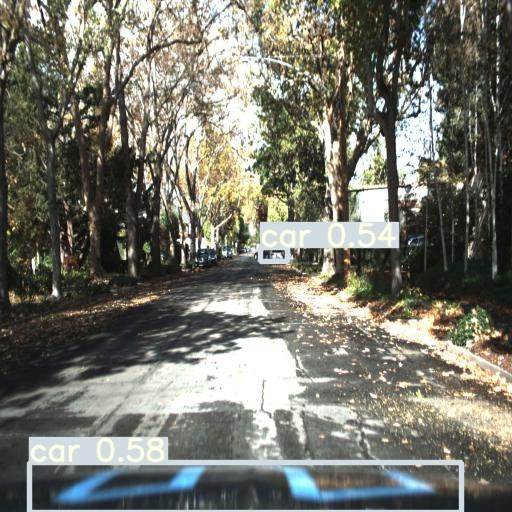

In [17]:
## detect 결과 // 결좌 저장되는 위치가 매번 바뀌어서(runs/detect/exp8 || runs/detect/exp9 ,,,) 기존 소스 코드 수정 필요 

Image(os.path.join('runs/detect/exp8', os.path.basename(val_img_path)))

In [18]:
## youtube 동영상 넣고 (초반 30초) 테스트 (https://youtu.be/K9yV3it3ntw)

! python detect.py --source ./driving_cut.mp4 --weights yolov5s.pt --conf 0.30

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.3, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', nosave=False, project='runs/detect', save_conf=False, save_txt=False, source='./driving_cut.mp4', update=False, view_img=False, weights=['yolov5s.pt'])
YOLOv5 🚀 v4.0-174-g9c803f2 torch 1.8.0 CUDA:0 (GeForce RTX 2080, 7982.3125MB)
                                       CUDA:1 (GeForce RTX 2080, 7974.3125MB)

Fusing layers... 
Model Summary: 224 layers, 7266973 parameters, 0 gradients, 17.0 GFLOPS
video 1/1 (1/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 Done. (0.009s)
video 1/1 (2/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 Done. (0.007s)
video 1/1 (3/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 Done. (0.008s)
video 1/1 (4/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 Done. (0.007s)
video 1/1 (5/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 Done. (0.007s)
vi

video 1/1 (85/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 Done. (0.009s)
video 1/1 (86/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 Done. (0.007s)
video 1/1 (87/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 Done. (0.007s)
video 1/1 (88/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 Done. (0.007s)
video 1/1 (89/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 Done. (0.008s)
video 1/1 (90/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 Done. (0.007s)
video 1/1 (91/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 Done. (0.007s)
video 1/1 (92/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 Done. (0.007s)
video 1/1 (93/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 Done. (0.007s)
video 1/1 (94/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 Done. (0.007s)
video 1/1 (95/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 Don

video 1/1 (173/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.007s)
video 1/1 (174/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 2 cars, Done. (0.008s)
video 1/1 (175/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.008s)
video 1/1 (176/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 Done. (0.007s)
video 1/1 (177/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 Done. (0.007s)
video 1/1 (178/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 Done. (0.007s)
video 1/1 (179/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.007s)
video 1/1 (180/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 Done. (0.007s)
video 1/1 (181/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.008s)
video 1/1 (182/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 Done. (0.007s)
video 1/1 (183/1950) /home/piai/AI

video 1/1 (263/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 Done. (0.010s)
video 1/1 (264/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 Done. (0.007s)
video 1/1 (265/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 Done. (0.007s)
video 1/1 (266/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 Done. (0.007s)
video 1/1 (267/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 Done. (0.008s)
video 1/1 (268/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 Done. (0.007s)
video 1/1 (269/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 Done. (0.007s)
video 1/1 (270/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 Done. (0.010s)
video 1/1 (271/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 Done. (0.007s)
video 1/1 (272/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 Done. (0.010s)
video 1/1 (273/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 

video 1/1 (351/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.008s)
video 1/1 (352/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, 1 truck, Done. (0.008s)
video 1/1 (353/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.008s)
video 1/1 (354/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.008s)
video 1/1 (355/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.008s)
video 1/1 (356/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.008s)
video 1/1 (357/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.008s)
video 1/1 (358/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.008s)
video 1/1 (359/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.007s)
video 1/1 (360/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. 

video 1/1 (435/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.008s)
video 1/1 (436/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.009s)
video 1/1 (437/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.008s)
video 1/1 (438/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.008s)
video 1/1 (439/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 2 cars, Done. (0.009s)
video 1/1 (440/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.008s)
video 1/1 (441/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.007s)
video 1/1 (442/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.008s)
video 1/1 (443/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.009s)
video 1/1 (444/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.008s)

video 1/1 (517/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.012s)
video 1/1 (518/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.008s)
video 1/1 (519/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.009s)
video 1/1 (520/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.009s)
video 1/1 (521/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.007s)
video 1/1 (522/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.009s)
video 1/1 (523/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.008s)
video 1/1 (524/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.008s)
video 1/1 (525/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.008s)
video 1/1 (526/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.009s)


video 1/1 (599/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.008s)
video 1/1 (600/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.009s)
video 1/1 (601/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.019s)
video 1/1 (602/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.008s)
video 1/1 (603/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.008s)
video 1/1 (604/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.007s)
video 1/1 (605/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.007s)
video 1/1 (606/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.008s)
video 1/1 (607/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.009s)
video 1/1 (608/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.008s)


video 1/1 (682/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 2 cars, Done. (0.008s)
video 1/1 (683/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 2 cars, Done. (0.008s)
video 1/1 (684/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 2 cars, Done. (0.008s)
video 1/1 (685/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 2 cars, Done. (0.008s)
video 1/1 (686/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 2 cars, Done. (0.008s)
video 1/1 (687/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 2 cars, Done. (0.011s)
video 1/1 (688/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 2 cars, Done. (0.010s)
video 1/1 (689/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 2 cars, Done. (0.008s)
video 1/1 (690/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 2 cars, Done. (0.008s)
video 1/1 (691/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 2 cars, Done.

video 1/1 (764/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 3 cars, Done. (0.007s)
video 1/1 (765/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 3 cars, Done. (0.009s)
video 1/1 (766/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 3 cars, Done. (0.007s)
video 1/1 (767/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 3 cars, Done. (0.009s)
video 1/1 (768/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 2 cars, Done. (0.008s)
video 1/1 (769/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 3 cars, Done. (0.008s)
video 1/1 (770/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 3 cars, Done. (0.008s)
video 1/1 (771/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 3 cars, Done. (0.009s)
video 1/1 (772/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 3 cars, Done. (0.008s)
video 1/1 (773/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 3 cars, Done.

video 1/1 (848/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 2 cars, Done. (0.008s)
video 1/1 (849/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 2 cars, Done. (0.008s)
video 1/1 (850/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 2 cars, Done. (0.008s)
video 1/1 (851/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 2 cars, Done. (0.010s)
video 1/1 (852/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 2 cars, Done. (0.011s)
video 1/1 (853/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 2 cars, Done. (0.008s)
video 1/1 (854/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 2 cars, Done. (0.008s)
video 1/1 (855/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 2 cars, Done. (0.008s)
video 1/1 (856/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 3 cars, Done. (0.008s)
video 1/1 (857/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 3 cars, Done.

video 1/1 (931/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.008s)
video 1/1 (932/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.008s)
video 1/1 (933/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 Done. (0.008s)
video 1/1 (934/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.007s)
video 1/1 (935/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 2 cars, Done. (0.008s)
video 1/1 (936/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 2 cars, Done. (0.008s)
video 1/1 (937/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.007s)
video 1/1 (938/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 2 cars, Done. (0.009s)
video 1/1 (939/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.008s)
video 1/1 (940/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.009s)
vide

video 1/1 (1012/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 2 cars, Done. (0.008s)
video 1/1 (1013/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 2 cars, Done. (0.008s)
video 1/1 (1014/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.010s)
video 1/1 (1015/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.008s)
video 1/1 (1016/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.010s)
video 1/1 (1017/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.007s)
video 1/1 (1018/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.008s)
video 1/1 (1019/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.008s)
video 1/1 (1020/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.007s)
video 1/1 (1021/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 2 cars, Do

video 1/1 (1095/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.008s)
video 1/1 (1096/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 2 cars, Done. (0.008s)
video 1/1 (1097/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.010s)
video 1/1 (1098/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 Done. (0.007s)
video 1/1 (1099/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 Done. (0.009s)
video 1/1 (1100/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 Done. (0.007s)
video 1/1 (1101/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 Done. (0.007s)
video 1/1 (1102/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 Done. (0.009s)
video 1/1 (1103/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 person, Done. (0.008s)
video 1/1 (1104/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 Done. (0.008s)
video 1/1 (1105/1950) /home/

video 1/1 (1181/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.009s)
video 1/1 (1182/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 2 cars, Done. (0.008s)
video 1/1 (1183/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.008s)
video 1/1 (1184/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.008s)
video 1/1 (1185/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 2 cars, Done. (0.008s)
video 1/1 (1186/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 2 cars, Done. (0.009s)
video 1/1 (1187/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 2 cars, Done. (0.008s)
video 1/1 (1188/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 2 cars, Done. (0.007s)
video 1/1 (1189/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 2 cars, Done. (0.008s)
video 1/1 (1190/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car,

video 1/1 (1263/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 2 cars, Done. (0.008s)
video 1/1 (1264/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 2 cars, Done. (0.008s)
video 1/1 (1265/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 3 cars, Done. (0.008s)
video 1/1 (1266/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 3 cars, Done. (0.008s)
video 1/1 (1267/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 2 cars, Done. (0.007s)
video 1/1 (1268/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 3 cars, Done. (0.007s)
video 1/1 (1269/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 2 cars, Done. (0.008s)
video 1/1 (1270/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 2 cars, Done. (0.007s)
video 1/1 (1271/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 3 cars, Done. (0.007s)
video 1/1 (1272/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 3 c

video 1/1 (1346/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 2 cars, Done. (0.008s)
video 1/1 (1347/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 2 cars, Done. (0.008s)
video 1/1 (1348/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 2 cars, Done. (0.008s)
video 1/1 (1349/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 2 cars, Done. (0.008s)
video 1/1 (1350/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 2 cars, Done. (0.007s)
video 1/1 (1351/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 2 cars, Done. (0.007s)
video 1/1 (1352/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 2 cars, Done. (0.008s)
video 1/1 (1353/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 2 cars, Done. (0.008s)
video 1/1 (1354/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 2 cars, Done. (0.008s)
video 1/1 (1355/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 2 c

video 1/1 (1426/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 2 cars, Done. (0.008s)
video 1/1 (1427/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.008s)
video 1/1 (1428/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.008s)
video 1/1 (1429/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.008s)
video 1/1 (1430/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.008s)
video 1/1 (1431/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.008s)
video 1/1 (1432/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.009s)
video 1/1 (1433/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.008s)
video 1/1 (1434/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.007s)
video 1/1 (1435/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done

video 1/1 (1508/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 3 cars, Done. (0.008s)
video 1/1 (1509/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 3 cars, Done. (0.008s)
video 1/1 (1510/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 2 cars, Done. (0.008s)
video 1/1 (1511/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 3 cars, Done. (0.008s)
video 1/1 (1512/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 3 cars, Done. (0.010s)
video 1/1 (1513/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 3 cars, Done. (0.008s)
video 1/1 (1514/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 2 cars, Done. (0.010s)
video 1/1 (1515/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 2 cars, Done. (0.007s)
video 1/1 (1516/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.007s)
video 1/1 (1517/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 ca

video 1/1 (1591/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.008s)
video 1/1 (1592/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.008s)
video 1/1 (1593/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.008s)
video 1/1 (1594/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 Done. (0.007s)
video 1/1 (1595/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.008s)
video 1/1 (1596/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 Done. (0.007s)
video 1/1 (1597/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 bus, Done. (0.008s)
video 1/1 (1598/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, 1 truck, Done. (0.011s)
video 1/1 (1599/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 Done. (0.009s)
video 1/1 (1600/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 truck, Done. (0.008s)


video 1/1 (1672/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 4 cars, 1 truck, Done. (0.008s)
video 1/1 (1673/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 3 cars, 1 truck, Done. (0.008s)
video 1/1 (1674/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 2 cars, 1 truck, Done. (0.008s)
video 1/1 (1675/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 3 cars, 1 truck, Done. (0.008s)
video 1/1 (1676/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 3 cars, 1 truck, Done. (0.008s)
video 1/1 (1677/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 4 cars, 1 truck, Done. (0.008s)
video 1/1 (1678/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 3 cars, 1 truck, Done. (0.009s)
video 1/1 (1679/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 3 cars, 1 truck, Done. (0.008s)
video 1/1 (1680/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 3 cars, 1 truck, Done. (0.008s)
v

video 1/1 (1749/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 truck, Done. (0.008s)
video 1/1 (1750/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 truck, Done. (0.009s)
video 1/1 (1751/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 truck, Done. (0.010s)
video 1/1 (1752/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 truck, Done. (0.008s)
video 1/1 (1753/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 truck, Done. (0.009s)
video 1/1 (1754/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 truck, Done. (0.008s)
video 1/1 (1755/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, 1 truck, Done. (0.008s)
video 1/1 (1756/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 2 cars, Done. (0.009s)
video 1/1 (1757/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 2 cars, 1 truck, Done. (0.007s)
video 1/1 (1758/1950) /home/piai/AIProjectTest/yolov5/drivi

video 1/1 (1828/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.008s)
video 1/1 (1829/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.007s)
video 1/1 (1830/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, 1 truck, Done. (0.008s)
video 1/1 (1831/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, 1 truck, Done. (0.008s)
video 1/1 (1832/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, 1 truck, Done. (0.008s)
video 1/1 (1833/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, 1 truck, Done. (0.007s)
video 1/1 (1834/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, 1 truck, Done. (0.009s)
video 1/1 (1835/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 Done. (0.007s)
video 1/1 (1836/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 1 car, Done. (0.009s)
video 1/1 (1837/1950) /home/piai/AIProjectTest/yolov5

video 1/1 (1915/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 Done. (0.007s)
video 1/1 (1916/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 Done. (0.007s)
video 1/1 (1917/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 Done. (0.007s)
video 1/1 (1918/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 Done. (0.007s)
video 1/1 (1919/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 Done. (0.007s)
video 1/1 (1920/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 Done. (0.007s)
video 1/1 (1921/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 Done. (0.007s)
video 1/1 (1922/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 Done. (0.007s)
video 1/1 (1923/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 Done. (0.007s)
video 1/1 (1924/1950) /home/piai/AIProjectTest/yolov5/driving_cut.mp4: 384x640 Done. (0.007s)
video 1/1 (1925/1950) /home/piai/AIProjectTest/yolov5/drivin

In [ ]:
## youtube 동영상 넣고 (초반 30초) 테스트 (https://youtu.be/K9yV3it3ntw) ## 학습한 weight로 바꿔서 --> 둘다 성능 좋음

%cd /home/piai/AIProjectTest/yolov5/
! python detect.py --source ./driving_cut.mp4 --weights /home/piai/AIProjectTest/yolov5/runs/train/yolov5s_results2/weights/best.pt --conf 0.30

In [ ]:
import torch # Keep in mind that YOLOv5 runs on top of PyTorch, so we need to import it to the notebook

from IPython.display import Image #this is to render predictions

#!git clone https://github.com/ultralytics/yolov5 # Use this if you want to keep the official Ultralytics scripts.

!git clone https://github.com/zldrobit/yolov5.git
%cd yolov5
!git checkout tf-android

In [ ]:
#Let's navigate to yolov5 directory and install all dependencies indicated at requirements.txt file
#In addition, let's prompt if any GPU is available
!pip install -r requirements.txt
!pip install tensorflow == 2.3.1 #Keep this version of TF as YOLOv5 works well with it.
print('All set. Using PyTorch version %s with %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

In [ ]:
##이거 돌리기 
## pt --> onnx --> tflite 한번에 하는거 

!PYTHONPATH=. python3 /home/piai/yolo_donkey/yolov5/models/tf.py --weight /home/piai/yolo_donkey/yolov5_ori/best.pt --cfg /home/piai/yolo_donkey/yolov5/models/yolov5s.yaml --img 416

In [ ]:
## tflite 파일로 test

## detect.py 
'''
        #with open('data/coco.yaml') as f:
        with open('data/data.yaml') as f:
        
        수정
'''
import cv2 
from IPython.display import Image
import os
%cd /home/piai/yolo_donkey/yolov5/
#val_img_path = 'test_image.jpg' # test시 사용할 이미지 경로 
val_img_path = '/home/piai/yolo_donkey/yolov5/iOS 이미지1.jpg'
!python detect.py --weights best-fp16.tflite --img 416 --conf 0.5 --source "{val_img_path}"
